# 4. GWR

## 4.3 GWRの理論的側面

###4.3.1 準備

In [1]:
from google.colab import drive
drive.mount('/content/mount')

Mounted at /content/mount


In [2]:
%cd '/content/mount/MyDrive/SDS/'

/content/mount/MyDrive/SDS


In [3]:
!pip install -q libpysal
!pip install -q geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 20.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# サンプルデータセット"georgia"をインポートするためのパッケージ
import libpysal as ps
# 統計分布用パッケージ
import scipy.stats as st
# 自作のモジュール
from Functions.utils import *
from Functions.commons import *

In [5]:
# サンプルデータ"georgia"をインポートしてgeopandasデータフレームを作成
georgia = gpd.read_file(ps.examples.get_path('G_utm.shp'))

### 4.3.2 重みの決定(1)

In [6]:
# obj_name : geopandasデータフレームのオブジェクト名
# y_data : geopandasデータフレームの列名をリストにする  ex) georgia['PctBach']
# X_data : geopandasデータフレームの列名をリストにする  ex) georgia[['PctFB', 'PctBlack', 'PctRural']]
# pos_data : geopandasデータフレームの列名をリストにする  ex) georgia[['X', 'Y']]
# std : y_data,X_dataを標準化するか否か(デフォルトはFalse)

def get_input_data(y_data, X_data, pos_data, std=False):
  # データ数
  N = len(y_data)

  # データフレームをnp.arrayに変換する
  X = X_data.values.astype(np.float64)

  # Xを標準化
  if std == True:
    X = standardize(X)

  # 定数項の列(すべて1)を作成する
  intercept = np.ones(N).reshape([-1, 1])
  # 2つの配列を水平方向に結合する
  X = np.hstack([intercept, X])

  # y(被説明変数)をN×1配列に変換
  y = y_data.values.reshape(-1, 1).astype(np.float64)

  # yを標準化
  if std == True:
    y = standardize(y)

  # 位置情報(緯度経度)データのリストを作成する
  u = pos_data.iloc[:, 0].astype(np.float64)
  v = pos_data.iloc[:, 1].astype(np.float64)
  coords = list(zip(u, v))

  return y, X, coords

def standardize(x):
  x = (x - x.mean(axis=0)) / x.std(axis=0)
  return x

In [7]:
y, X, coords = get_input_data(georgia['PctBach'], georgia[['PctFB', 'PctBlack', 'PctRural']], georgia[['X', 'Y']])

In [8]:
#データ地点数
N = len(y)
# 緯度・経度を代入
lat = [coord[0] for coord in coords]
lng = [coord[1] for coord in coords]

# 地点0(i=0)における、他の地点jの重み
i = 0

# 地点0(i=0)から他の地点jへの距離を求める
d_lists = [ [j, np.sqrt((lat[j] - lat[i])**2 + (lng[j] - lng[i])**2)] for j in range(N)]

# sort関数でkeyをdistの各要素の2番目(距離)の要素に指定して並び替え
d_lists.sort(key=lambda x: x[1])

# 117番目の距離を抽出
b = d_lists[116][1]  # 基準地点も含むので117-1=116

# bi-square型カーネルで重みの計算
w_lists = [ [j, (1 - (d / b)**2)**2] if d <= b else [j, 0] for j, d in d_lists ]

# 重みをデータインデックス順に並び替え
w_lists.sort(key=lambda x: x[0])

In [9]:
# データ地点0(基準点)での重みの出力
w_lists

[[0, 1.0],
 [1, 0.8805795582808345],
 [2, 0.9874310292847397],
 [3, 0.20640035916148353],
 [4, 0.3704791256394162],
 [5, 0],
 [6, 0],
 [7, 0],
 [8, 0.8417382574268786],
 [9, 0.7562251135366999],
 [10, 0.34859962487942014],
 [11, 0.6397938967454694],
 [12, 0.8754564099157556],
 [13, 0.47895533770287274],
 [14, 0.8017603647350778],
 [15, 0.7713831783361299],
 [16, 0.47197896468501527],
 [17, 0.09295091611050327],
 [18, 0.12823341226311866],
 [19, 0.714281226534307],
 [20, 0.8338832513010057],
 [21, 0],
 [22, 0],
 [23, 0.7877740610465431],
 [24, 0.6328897022914448],
 [25, 0.04292886151756581],
 [26, 0],
 [27, 0],
 [28, 0.003557427891370895],
 [29, 0.03249806980954101],
 [30, 0.0],
 [31, 0.7531104195149948],
 [32, 0],
 [33, 0.9194535123746989],
 [34, 0.49750364687493825],
 [35, 0.2124035413957856],
 [36, 0.6245552676275149],
 [37, 0],
 [38, 0.27683602332143276],
 [39, 0.5614648464445583],
 [40, 0],
 [41, 0],
 [42, 0.07858095147430762],
 [43, 0],
 [44, 0.7758456982564853],
 [45, 0.500394021

In [10]:
# データインデックス順で重みを、リストとして抽出
weight_0 = [ w_list[1] for w_list in w_lists ]
# 重みが対角要素に並んだ「重み行列」の作成
W_0 = np.diag(weight_0)
# データ地点0(基準点)における重み行列の出力
print(W_0)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.88057956 0.         ... 0.         0.         0.        ]
 [0.         0.         0.98743103 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.07176091 0.         0.        ]
 [0.         0.         0.         ... 0.         0.52883223 0.        ]
 [0.         0.         0.         ... 0.         0.         0.51748884]]


In [11]:
#データ地点数
N = len(y)
# 緯度・経度を代入
lat = [coord[0] for coord in coords]
lng = [coord[1] for coord in coords]

#空のweight_listを作成
weight_list = []

####################各地点のループはここから####################

for i in range(N):
  # 地点iから他の地点jへの距離を求める
  d_lists = [ [j, np.sqrt((lat[j] - lat[i])**2 + (lng[j] - lng[i])**2)] for j in range(N)]

  # sort関数でkeyをdistの各要素の2番目(距離)の要素に指定して並び替え
  d_lists.sort(key=lambda x: x[1])

  # 117番目の距離を抽出
  b = d_lists[116][1]  # 基準地点も含むので117-1=116

  # bi-square型カーネルで重みの計算
  w_lists = [ [j, (1 - (d / b)**2)**2] if d <= b else [j, 0] for j, d in d_lists ]

  # 重みをデータインデックス順に並び替え
  w_lists.sort(key=lambda x: x[0])

  # データインデックス順で重みを、リストとして抽出
  weight_i = [ w_list[1] for w_list in w_lists ]

  # 各地点のweightを縦方向に積み上げたnumpy配列(N×N)を作成
  weight_list.append(weight_i)  # リストに追加

####################各地点のループはここまで####################

# リストをnp.ndarray型に変換
weight_list = np.array(weight_list)

In [12]:
print(weight_list)

[[1.         0.88057956 0.98743103 ... 0.07176091 0.52883223 0.51748884]
 [0.89174593 1.         0.94716479 ... 0.00391639 0.42144256 0.78966022]
 [0.98814238 0.94488792 1.         ... 0.04290548 0.49389562 0.61322028]
 ...
 [0.01647016 0.         0.         ... 1.         0.61308926 0.        ]
 [0.23567942 0.07172614 0.16455022 ... 0.43063296 1.         0.11632662]
 [0.48202715 0.74952069 0.5617097  ... 0.         0.38368485 1.        ]]


###4.3.3 重みの決定(2)

In [13]:
# distance.cdistモジュールのインポート
from scipy.spatial import distance

# 距離行列の作成(ユークリッド距離)
dist_mat = distance.cdist(coords, coords, metric=distance.euclidean)

In [14]:
# 昇順でdist_listを並べたリスト
sorted_dist_list = np.sort(dist_mat, axis=1)
# 確認
print(sorted_dist_list)

[[     0.          21664.09954372  27222.5027705  ... 427175.76721467
  435434.03908341 451733.73514416]
 [     0.          20577.84099001  36065.08761725 ... 439436.52117656
  450846.60774193 462414.5479369 ]
 [     0.          21664.09954372  30666.96411059 ... 434976.01563305
  444214.35473344 459109.13446087]
 ...
 [     0.          28306.1313676   28802.27891834 ... 351385.09379335
  364304.34622855 377227.22891039]
 [     0.          29204.46382593  29419.08225302 ... 285830.87583088
  293241.61268483 310827.4296515 ]
 [     0.          30666.64198506  32259.96323138 ... 385323.96378756
  397200.95408853 402648.23679043]]


In [15]:
# 昇順でdist_listを並べたインデックスのリスト
sorted_dist_list_idx = np.argsort(dist_mat, axis=1)
# 地点の順番をもとに戻すインデックスのリスト
reverse_dist_list_idx = np.argsort(sorted_dist_list_idx, axis=1)
# 確認
print(reverse_dist_list_idx)

[[  0  13   1 ...  95  48  49]
 [ 15   0   5 ... 108  59  25]
 [  1   5   0 ... 104  52  43]
 ...
 [107 131 117 ...   0  34 130]
 [ 69  89  80 ...  46   0  83]
 [ 54  30  48 ... 122  62   0]]


In [16]:
# バンド幅に基づく重みリストを作成する関数
def get_weight_list(N, sorted_dist_list, reverse_dist_list_idx, bw_idx):
  # バンド幅(bw_idx番目(原点も含む)の列ベクトルの作成)
  bw = sorted_dist_list[:,bw_idx].reshape([-1, 1])
  # bi-square型カーネルで重みづけ
  w = (1 - (sorted_dist_list / bw)**2)**2
  # バンド幅より遠い地点は重みを0とする
  w[:, bw_idx:] = 0
  # 順番をもとに戻す
  w_list = np.array([w[i, reverse_dist_list_idx[i]] for i in range(N)])

  return w_list

# 確認
w_list = get_weight_list(N, sorted_dist_list, reverse_dist_list_idx, 116)
print(w_list)

[[1.         0.88057956 0.98743103 ... 0.07176091 0.52883223 0.51748884]
 [0.89174593 1.         0.94716479 ... 0.00391639 0.42144256 0.78966022]
 [0.98814238 0.94488792 1.         ... 0.04290548 0.49389562 0.61322028]
 ...
 [0.01647016 0.         0.         ... 1.         0.61308926 0.        ]
 [0.23567942 0.07172614 0.16455022 ... 0.43063296 1.         0.11632662]
 [0.48202715 0.74952069 0.5617097  ... 0.         0.38368485 1.        ]]


In [17]:
# 重みリストから1行取り出して、重み行列を作成する関数
def get_weight_matrix(w_list):
  W = np.matrix(np.diag(w_list))

  return W

# 確認(第0地点)
W_0 =get_weight_matrix(w_list[0])
print(W_0)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.88057956 0.         ... 0.         0.         0.        ]
 [0.         0.         0.98743103 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.07176091 0.         0.        ]
 [0.         0.         0.         ... 0.         0.52883223 0.        ]
 [0.         0.         0.         ... 0.         0.         0.51748884]]


###4.3.4 GWRの線形回帰モデル

省略

###4.3.5 係数パラメータの求め方

In [18]:
# 地点0の係数パラメータを求める
beta_0_hat = np.linalg.inv(X.T @ W_0 @ X) @ X.T @ W_0 @ y
print(beta_0_hat)

[[14.22071124]
 [ 1.05161773]
 [ 0.01867334]
 [-0.08966088]]


In [19]:
# パラメータ推定値の格納オブジェクトbeta_hatを作成
beta_hat = np.zeros_like(X)

for i in range(N):
  # weight_listを用いて、重みが対角要素に並んだ「重み行列」の作成
  W_i = np.diag(weight_list[i])

  # 地点iの係数パラメータを求める
  beta_i_hat = np.linalg.inv(X.T @ W_i @ X) @ X.T @ W_i @ y
  beta_hat[i, :] = beta_i_hat.flatten()

In [20]:
# 係数パラメータの確認
print(beta_hat)

[[ 1.42207112e+01  1.05161773e+00  1.86733405e-02 -8.96608781e-02]
 [ 1.37287961e+01  7.60885754e-01  3.11904037e-02 -8.66691034e-02]
 [ 1.41084241e+01  9.43150004e-01  2.33396774e-02 -8.95014780e-02]
 [ 1.36867700e+01  7.03891785e-01  1.67276369e-02 -7.55529277e-02]
 [ 1.33699603e+01  3.30070586e+00 -5.54557885e-02 -5.06474756e-02]
 [ 1.33001359e+01  3.32578924e+00 -2.75323495e-02 -6.31813339e-02]
 [ 1.33525551e+01  3.30449013e+00 -3.02309537e-02 -6.22967519e-02]
 [ 1.22995105e+01  3.29870622e+00 -1.60421696e-02 -5.61929036e-02]
 [ 1.29596674e+01  9.66573587e-01  3.14180159e-02 -7.83038844e-02]
 [ 1.34442390e+01  7.01749069e-01  3.24036210e-02 -8.27645699e-02]
 [ 1.40756918e+01  2.75985082e+00 -5.27744842e-02 -5.57718355e-02]
 [ 1.33380775e+01  1.91683977e+00 -9.42739330e-03 -6.67526303e-02]
 [ 1.46942944e+01  8.40464368e-01  2.08953662e-02 -9.49100274e-02]
 [ 1.34754363e+01  5.84003477e-01  3.26673165e-02 -8.20149992e-02]
 [ 1.51706311e+01  1.27238751e+00 -1.91678297e-03 -9.31209926e

In [21]:
# 配列の縦方向で最小値・中央値・最大値を求めるのでaxis=0
# 各パラメータの平均値
beta_mean = np.mean(beta_hat, axis=0)
# 各パラメータの標準偏差
beta_std = np.std(beta_hat, axis=0)
# 各パラメータの最小値
beta_min = np.min(beta_hat, axis=0)
# 各パラメータの中央値
beta_median = np.median(beta_hat, axis=0)
# 各パラメータの最大値
beta_max = np.max(beta_hat, axis=0)

print(f'beta_mean: {np.round(beta_mean, 3)}')
print(f'beta_std: {np.round(beta_std, 3)}')
print(f'beta_min: {np.round(beta_min, 3)}')
print(f'beta_median: {np.round(beta_median, 3)}')
print(f'beta_max: {np.round(beta_max, 3)}')

beta_mean: [13.653  2.2   -0.014 -0.069]
beta_std: [0.815 1.078 0.027 0.013]
beta_min: [11.947  0.568 -0.056 -0.097]
beta_median: [13.636  2.564 -0.017 -0.065]
beta_max: [15.411  3.415  0.033 -0.051]


### 4.3.6 $y$の理論値と残差平方和

In [22]:
# 理論値y_hatを求める
# 1行列を作成
ones = np.ones(X.shape[1]).reshape([-1, 1])

# 行列どうしのアダマール積を求める場合はnp.maltiply(A, B)
y_hat = np.multiply(beta_hat, X) @ ones

In [23]:
# yの理論値の確認
print(y_hat)

[[ 8.50304276]
 [ 7.10185949]
 [ 9.20073125]
 [ 7.07322229]
 [13.57655163]
 [ 8.01668295]
 [12.02247377]
 [10.63099486]
 [10.58268055]
 [ 9.17683594]
 [13.90356666]
 [10.48908109]
 [ 5.57634569]
 [10.47781209]
 [ 8.20918924]
 [11.06603042]
 [ 8.17565094]
 [10.17550244]
 [ 6.97856059]
 [12.46080646]
 [11.5068001 ]
 [11.04483376]
 [10.95590726]
 [ 6.12654675]
 [17.35051162]
 [23.79536289]
 [ 8.05653195]
 [14.3666748 ]
 [26.43264548]
 [ 7.13805918]
 [25.5505893 ]
 [ 9.71230707]
 [25.5042454 ]
 [10.12351694]
 [11.22763303]
 [22.70238665]
 [10.54116151]
 [10.46392589]
 [ 9.47942959]
 [10.68055746]
 [ 9.17555143]
 [ 8.73663028]
 [10.95373845]
 [33.42557467]
 [ 8.66483005]
 [ 9.22558051]
 [14.39707113]
 [15.19107023]
 [10.67465282]
 [ 6.45696202]
 [ 8.19915935]
 [10.98449832]
 [ 9.47742447]
 [ 6.49530372]
 [ 8.55709883]
 [18.73545186]
 [13.50641928]
 [11.11525962]
 [ 9.05851982]
 [24.64743057]
 [ 8.13475012]
 [ 8.79953467]
 [14.70410666]
 [ 9.82929553]
 [10.40204415]
 [ 8.56557401]
 [28.68316

###4.3.7 ハット行列と誤差項の分散の推定値

In [25]:
# ハット行列Sの配列を作成
S = np.zeros((N, N))

for i in range(N):
  # 重みが対角要素に並んだ「重み行列」の作成
  W_i = np.diag(weight_list[i])

  # ハット行列Sの行ベクトルを求める
  r_i = X[i, :] @ np.linalg.inv(X.T @ W_i @ X) @ X.T @ W_i
  S[i, :] = r_i.flatten()

# Sの大きさを確認
S.shape

(159, 159)

In [26]:
# 有効パラメータ数
v1 = np.trace(S)

# 有効自由度
edf = N - v1

print(f'v1(有効パラメータ数): {v1:.3f}')
print(f'edf(有効自由度): {edf:.3f}')

v1(有効パラメータ数): 11.805
edf(有効自由度): 147.195


In [27]:
# sigma2/sigma
e = y - S @ y
rss = e.T @ e

sigma2_hat = rss[0, 0] / (N - v1)
sigma_hat = np.sqrt(sigma2_hat)

print(f'rss(残差平方和): {rss[0, 0]:.3f}')
print(f'sigma2_hat(誤差項の分散の推定値): {sigma2_hat:.3f}')
print(f'sigma_hat(誤差項の標準偏差の推定値): {sigma_hat:.3f}')

rss(残差平方和): 1650.860
sigma2_hat(誤差項の分散の推定値): 11.215
sigma_hat(誤差項の標準偏差の推定値): 3.349


###4.3.8 その他のグローバル指標

In [29]:
# 全変動
total_var = np.sum((np.asarray(y).flatten() - np.mean(y))**2)

# 決定係数
R2 = 1 - rss[0, 0] / total_var

# 自由度調整済み決定係数
adjR2 = 1 - (rss[0, 0] /(N - (v1 + 1)))/(total_var / (N - 1))

print(f'R2(決定係数): {R2:.3f}')
print(f'adjR2(自由度調整済み決定係数): {adjR2:.3f}')

R2(決定係数): 0.678
adjR2(自由度調整済み決定係数): 0.652


In [30]:
# 対数尤度
sigma2 = rss[0, 0] / N
mll = - N / 2.0 * np.log(2.0 * np.pi) - N / 2.0 * np.log(sigma2) - 1 / (2.0 * sigma2) * np.sum(rss)
# AIC パラメータ数は(v1+1)
aic = (-2.0) * mll + 2.0 * (v1 + 1)
# AICc パラメータ数は(v1+1)
aicc = (-2.0) * mll + (2.0 * (v1 + 1.0) * N) / (N - (v1 + 1.0) - 1.0)
# BIC パラメータ数は(v1+1)
bic = (-2.0) * mll + np.log(N) * (v1 + 1.0)

print(f'mll(対数尤度): {mll:.3f}')
print(f'aic(AIC): {aic:.3f}')
print(f'aicc(AICc): {aicc:.3f}')
print(f'bic(BIC): {bic:.3f}')

mll(対数尤度): -411.653
aic(AIC): 848.915
aicc(AICc): 851.350
bic(BIC): 888.212


###4.3.9 ローカル指標の確認

In [31]:
# local_R2を格納する配列を作成
local_R2 = np.zeros(N)

for i in range(N):
  # 重みが対角要素に並んだ「重み行列」の作成
  W_i = np.diag(weight_list[i])

  # 全変動
  local_y_bar = np.sum(W_i / np.trace(W_i) @ y)
  total_var_i = (y - local_y_bar).T @ W_i @ (y - local_y_bar)
  # 残差変動
  unexp_var_i = (y - y_hat).T @ W_i @ (y - y_hat)

  # 決定係数
  local_R2[i] = 1.0 - unexp_var_i[0, 0]/ total_var_i[0, 0]

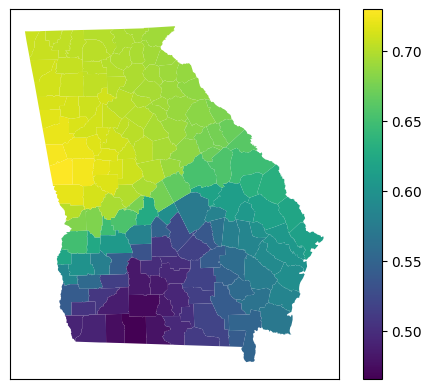

In [33]:
# georgiaデータフレームに'local_R2'を追加する
georgia['local_R2'] = local_R2
georgia.plot('local_R2', legend = True)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig('./Chapter4/figures/localR2_2.png')
plt.show()

In [34]:
# ローカル係数パラメータの標準誤差local_std
# およびt値local_tを格納する配列を作る
local_std = np.zeros_like(X)
local_t = np.zeros_like(X)

for i in range(N):
  # 重みが対角要素に並んだ「重み行列」の作成
  W_i = np.diag(weight_list[i])

  # パラメータ推定値の分散共分散行列の対角要素から標準誤差を求める
  C = np.linalg.inv(X.T @ W_i @ X) @ X.T @ W_i
  beta_i_hat_var = sigma2_hat * C @ C.T
  diag_i = np.diag(beta_i_hat_var).flatten()
  local_std[i, :] = np.sqrt(diag_i)

  # t値を求める
  local_t[i, :] = beta_hat[i, :] / local_std[i, :]

In [35]:
print(local_std)

[[1.87726918 0.51471885 0.02871881 0.01699497]
 [1.74505135 0.41545885 0.02799731 0.01606696]
 [1.82713632 0.47987405 0.02825463 0.01660144]
 [1.87762438 0.38262641 0.03027924 0.01748751]
 [1.91185287 0.38996908 0.02465731 0.01851118]
 [1.80356199 0.38761671 0.01975666 0.01783988]
 [1.77544773 0.38049952 0.01951076 0.01747487]
 [1.79669722 0.37205366 0.01926    0.01782306]
 [1.75734564 0.42451816 0.02743105 0.0162856 ]
 [1.70671365 0.38465452 0.02781479 0.01585862]
 [1.93240555 0.39014149 0.02552943 0.01901137]
 [1.9632988  0.44905742 0.02927392 0.01880073]
 [1.87076725 0.48038549 0.02931935 0.01713195]
 [1.74235947 0.3796981  0.02876511 0.01622243]
 [1.96960622 0.55204871 0.03026736 0.01823873]
 [1.92781686 0.53614724 0.0291452  0.01812744]
 [1.95254143 0.46551042 0.02744289 0.01874409]
 [1.9333344  0.39811708 0.02151688 0.01892068]
 [1.84572169 0.37520374 0.02934409 0.01742745]
 [1.88972903 0.47830995 0.02976141 0.01737959]
 [1.91412715 0.53263587 0.02890895 0.01790849]
 [1.77739793 

In [36]:
# 配列の縦方向で最小値・中央値・最大値を求めるのでaxis=0
# 各パラメータの標準偏差の平均値
local_std_mean = np.mean(local_std, axis=0)
print(local_std_mean)

[1.85868759 0.41407817 0.02490936 0.01783873]


In [37]:
print(local_t)

[[ 7.57521157  2.04309154  0.650213   -5.27572887]
 [ 7.86727343  1.83143471  1.11404991 -5.39424313]
 [ 7.72160456  1.96541156  0.82604795 -5.39118775]
 [ 7.2894079   1.83963197  0.55244577 -4.32039474]
 [ 6.99319522  8.4640194  -2.24906085 -2.73604849]
 [ 7.37437139  8.58009773 -1.39357324 -3.5415791 ]
 [ 7.52066926  8.6846105  -1.5494505  -3.56493324]
 [ 6.84562227  8.86621085 -0.83292658 -3.15282027]
 [ 7.37456943  2.27687217  1.14534502 -4.80816626]
 [ 7.87726694  1.82436195  1.164978   -5.21889969]
 [ 7.28402579  7.0739742  -2.06720197 -2.93360491]
 [ 6.79370733  4.26858498 -0.32204067 -3.55053385]
 [ 7.8546887   1.74956236  0.71268188 -5.53994429]
 [ 7.73401618  1.53807322  1.13565769 -5.05565382]
 [ 7.70236759  2.30484647 -0.06332837 -5.10567363]
 [ 7.70994513  3.17615272 -0.56529675 -4.66557392]
 [ 7.25283657  5.85198133 -1.7298708  -3.45307704]
 [ 7.13355589  7.86717251 -2.26400366 -2.98301322]
 [ 7.71634147  2.20154102  0.16865937 -4.38257775]
 [ 7.89294211  1.66516198  0.67

In [38]:
# 配列の縦方向で最小値・中央値・最大値を求めるのでaxis=0
# 各パラメータのt値の平均値
local_t_mean = np.mean(local_t, axis=0)
print(local_t_mean)

[ 7.35170706  5.48336658 -0.68710708 -3.88834422]


In [39]:
# ラベルリスト
lbl_list = ['Intercept_t', 'PctFB_t', 'PctBlack_t', 'PctRural_t']
# georgiaデータフレームにローカル係数パラメータのt値を追加する
georgia[lbl_list] = local_t
# 確認
georgia.head(3)

,AREA,PERIMETER,G_UTM_,G_UTM_ID,Latitude,Longitud,TotPop90,PctRural,PctBach,PctEld,...,PctBlack,X,Y,AreaKey,geometry,local_R2,Intercept_t,PctFB_t,PctBlack_t,PctRural_t
0,1.331370e+09,207205.0,132,133,31.75339,-82.28558,15744,75.6,8.2,11.43,...,20.76,941396.6,3521764,13001,"POLYGON ((931869.062 3545540.500, 934111.625 3...",0.559329,7.575212,2.043092,0.650213,-5.275729
1,8.929300e+08,154640.0,157,158,31.29486,-82.87474,6213,100.0,6.4,11.77,...,26.86,895553.0,3471916,13003,"POLYGON ((867016.312 3482416.000, 884309.375 3...",0.514871,7.867273,1.831435,1.114050,-5.394243
2,7.434020e+08,130431.0,148,146,31.55678,-82.45115,9566,61.7,6.6,11.11,...,15.42,930946.4,3502787,13005,"POLYGON ((914656.875 3512190.000, 924718.375 3...",0.547518,7.721605,1.965412,0.826048,-5.391188


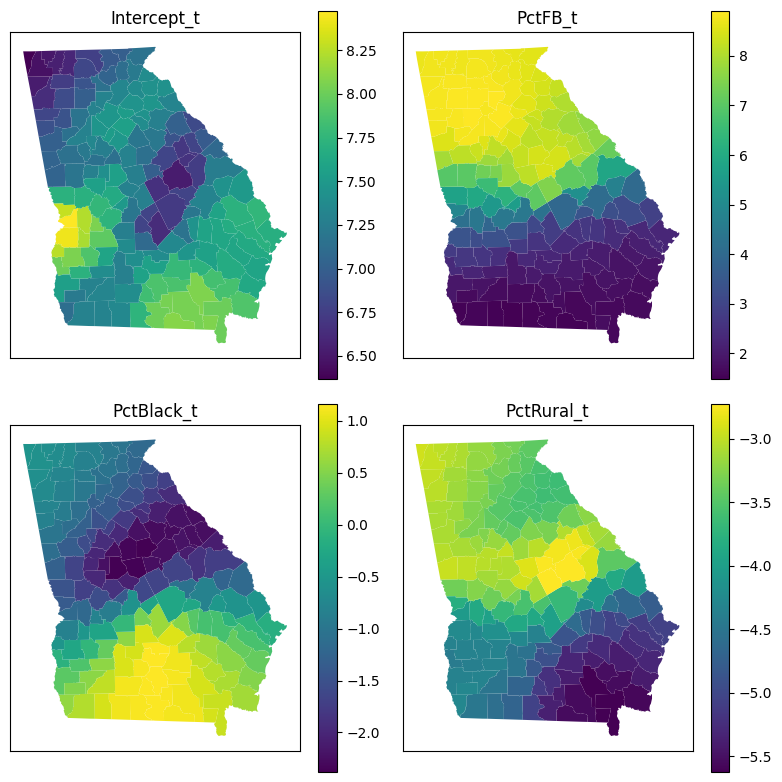

In [40]:
fig, axes = plt.subplots(2,2,figsize=(8,8))

# axes.ravel()で2次元配列のaxesを1次元配列にする
for ax, lbl in zip(axes.ravel(), lbl_list):
  georgia.plot(lbl, ax=ax, legend=True)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title(lbl)

fig.tight_layout()
plt.savefig('./Chapter4/figures/local_tvals_2.png')
plt.show()

##4.4 黄金分割探索法(Golden Section Search)

###4.4.1 黄金分割探索法(Golden Section Search)

In [41]:
def eval_func(x):
  y = 0.5 * x**2 - 4 * x + 12
  return y

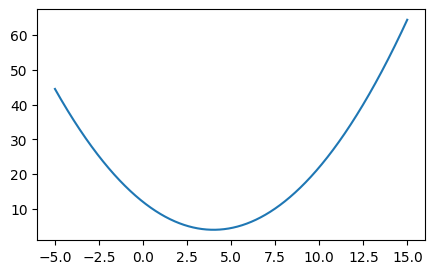

In [42]:
# 下限と上限
lb = -5.0
ub = 15.0

fig, ax = plt.subplots(1,1,figsize=(5,3))

x = np.arange(lb, ub, 0.01)
ax = plt.plot(x, eval_func(x))

plt.show()

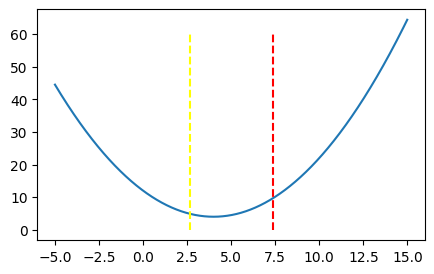

In [43]:
# 黄金比
gr = (np.sqrt(5) - 1) / 2  # おおよそ0.61803…

# 下限と上限
lb = -5.0
ub = 15.0

fig, ax = plt.subplots(1,1,figsize=(5,3))

x = np.arange(lb, ub, 0.01)
ax = plt.plot(x, eval_func(x))

x1 = lb + gr * (ub - lb)
x2 = ub - gr * (ub - lb)
ax = plt.vlines(x1, 0, 60, 'red', 'dashed')  # X1
ax = plt.vlines(x2, 0, 60, 'yellow', 'dashed')  # X2

plt.show()

In [44]:
# 下限および上限の初期値
init_lb = -5
init_ub = 15

# 黄金比
gr = (np.sqrt(5) - 1) / 2  # おおよそ0.61803…

# 収束判断をする閾値
threshold = 1e-5

# 下限と上限
lb = init_lb
ub = init_ub
diff = 1e+5  # 2点における評価関数の差の初期値

while diff > threshold:
  # x1 and x2 (x2 < x1)
  x1 = lb + gr * (ub - lb)
  x2 = ub - gr * (ub - lb)

  # y1 and y2
  y1 = eval_func(x1)
  y2 = eval_func(x2)
  diff = np.abs(y1 - y2)  # 評価関数の値の差の絶対値

  if y1 > y2:
    lb = lb
    ub = x1  # 評価関数の値が大きい方を新たな領域の上限とする
  else:
    lb = x2  # 評価関数の値が大きい方を新たな領域の下限とする
    ub = ub

  print('({0:.4f}, {1:.4f})'.format(x1, x2))

(7.3607, 2.6393)
(2.6393, -0.2786)
(4.4427, 2.6393)
(5.5573, 4.4427)
(4.4427, 3.7539)
(3.7539, 3.3282)
(4.0170, 3.7539)
(4.1796, 4.0170)
(4.0170, 3.9165)
(4.0791, 4.0170)
(4.0170, 3.9786)
(4.0407, 4.0170)
(4.0170, 4.0023)
(4.0023, 3.9933)
(4.0079, 4.0023)
(4.0023, 3.9989)


###4.4.2 最適バンド幅の計算

In [45]:
def calc_aicc(bw_idx): # AICcを求める
  # 重みリストの作成
  w_list = get_weight_list(N, sorted_dist_list, reverse_dist_list_idx, bw_idx)
  # 空のハット行列の作成
  S = np.zeros(shape=(N, N))

  for i in range(N):
    # 重み行列の作成
    W_i = get_weight_matrix(w_list[i]) # 定義したget_weight_matrix()を使用
    # 地点iのハット行列の一部(R_i)を求める
    S[i, :] = np.matrix(X[i, :]) @ np.linalg.inv(X.T @ W_i @ X) @ X.T @ W_i

  # yの理論値
  y_hat = get_y_hat(y, S)

  # 残差
  resid = get_resid(y, y_hat)

  # 残差平方和
  rss = get_rss(resid)

  # 対数尤度
  mll = get_mll(y, y_hat, rss, N)

  # 有効パラメータ数
  v1 = get_v1(S)

  # AICc パラメータ数は(v1+1)
  aicc = get_aicc(mll, N, v1+1)

  return aicc

In [46]:
# 黄金分割探索法
def search():  # バンド幅の最小値bw_min・最大値bw_max
  # 黄金分割比
  gr = (np.sqrt(5) - 1) / 2  # おおよそ0.61803…

  # バンド幅の最大最小の初期値
  init_lb = 1  # バンド幅の最小値
  init_ub = N  # バンド幅の最大値

  # バンド幅の下限と上限の設定
  lb = init_lb
  ub = init_ub
  diff = 1e+5  # diffはy1とy2の差の絶対値(初期値は1e+5としている)

  while diff > 1e-5:  # 閾値は1e-5
    # 黄金分割費に基づいてバンド幅x1とx2 (x2 < x1) を決める
    # 整数のインデックスにするするため、np.round()で四捨五入
    x1 = np.round(lb + gr * (ub - lb)).astype('int64')
    x2 = np.round(ub - gr * (ub - lb)).astype('int64')

    # y1(x1に対応するAICc)
    y1 = calc_aicc(x1)
    # y2(x2に対応するAICc)
    y2 = calc_aicc(x2)

    diff = np.abs(y1 - y2)  # diffはy1とy2の差の絶対値

    if y1 > y2:  # 走査する範囲の上限をx1に狭める
      lb = lb
      ub = x1
    else:  # 走査する範囲の下限をx2に狭める
      lb = x2
      ub = ub

    print((x1, x2))

  return(x1 + 1)

In [47]:
search()

(99, 61)
(122, 98)
(136, 121)
(121, 113)
(112, 107)
(116, 112)
(118, 115)
(116, 114)
(116, 116)


117